In [1]:
from numpy import *
from matplotlib.pyplot import *
import os
import sys
src_dir = os.environ.get('srcdir')
sys.path.append(src_dir)

from features.calc_z import calc_z
from features.make_roms_ds import make_4D_mask, make_3D_XiEta, make_4D_depth
import matplotlib.pyplot as plt
import xarray as xr

In [2]:
grd_path = out_path = os.path.join(os.environ.get('prodir'),'waom10_stable_grd.nc')
grd = xr.open_dataset(grd_path)

In [3]:
grd.coords['s_rho']=range(31)
mask_3d = np.tile(grd.mask_rho,(grd.s_rho.size,1,1))

grd['mask_3d'] = xr.DataArray(mask_3d,dims=['s_rho','eta_rho','xi_rho'])
grd.mask_3d.attrs = grd.mask_rho.attrs


In [4]:
xi_3d = np.tile(grd.xi_rho,(grd.s_rho.size,grd.eta_rho.size,1))
eta_3d = np.swapaxes(np.tile(grd.eta_rho,(grd.s_rho.size,grd.xi_rho.size,1)),1,2)

xi_3d_da = xr.DataArray(xi_3d,dims=['s_rho','eta_rho','xi_rho'])
eta_3d_da = xr.DataArray(eta_3d,dims=['s_rho','eta_rho','xi_rho'])

grd = grd.assign_coords(xi_3d=xi_3d_da)
grd = grd.assign_coords(eta_3d=eta_3d_da)

#grd['xi_3d'] = grd.xi_3d.where(grd.mask_rho == 1)
#grd['eta_3d'] = grd.eta_3d.where(grd.mask_rho ==1)

grd.xi_3d.attrs = grd.xi_rho.attrs
grd.eta_3d.attrs = grd.eta_rho.attrs

In [5]:
h = grd.h.values
zice = grd.zice.values
theta_s = 7
theta_b = 10
hc = 250
N = grd.s_rho.size
zeta = np.zeros_like(h)

depths,s,C = calc_z(h,zice,theta_s,theta_b,hc,N)

grd = grd.assign_coords(depth = xr.DataArray(depths,dims=['s_rho','eta_rho','xi_rho']))

<IPython.core.display.Javascript object>


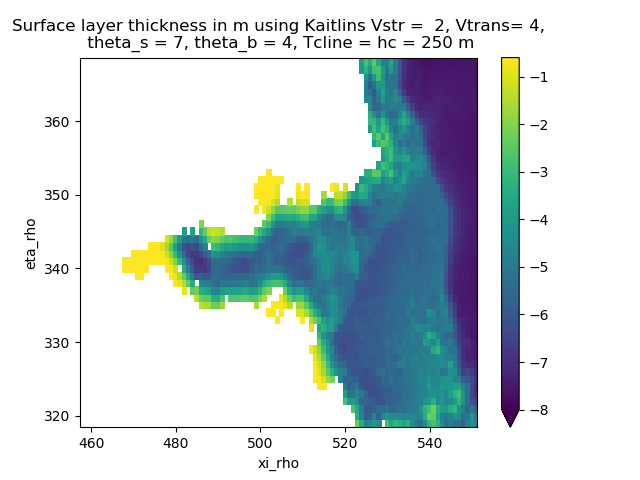

In [127]:
plt.close()
((grd.depth[30]-grd.zice)*2).where(grd.mask_rho).plot(vmin=-8)
plt.title('Surface layer thickness in m using Kaitlins Vstr =  2, Vtrans= 4,\n theta_s = 7, theta_b = 4, Tcline = hc = 250 m')
plt.show()

In [6]:
from pyroms import vgrid
h = grd.h.values+grd.zice.values
theta_s = 4
theta_b = 0.9
hc = 20
zeta = np.zeros_like(h)
Tcline = 20
s = vgrid.s_coordinate(h,theta_b,theta_s,Tcline,N)
z_r = vgrid.z_r(h,hc,s.N,s.s_rho,s.Cs_r,zeta,Vtrans=1)

/home/ubuntu/bigStick/anaconda3/envs/tidal_melting/lib/python3.6/site-packages/pyroms/vgrid.py:40: UserWarning: Vertical transformation parameters are not defined correctly in either gridid.txt or in the history files: 
 Tcline = 20 and hmin = 0. 
 You need to make sure that Tcline <= hmin when using transformation 1.
  warnings.warn('Vertical transformation parameters are not defined correctly in either gridid.txt or in the history files: \n Tcline = %d and hmin = %d. \n You need to make sure that Tcline <= hmin when using transformation 1.' %(self.Tcline,self.hmin))


In [99]:
plt.close()

<IPython.core.display.Javascript object>


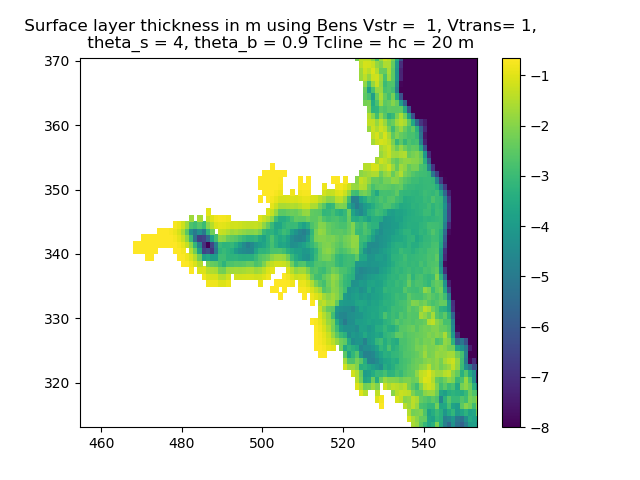

In [128]:
plt.close()
plt.pcolormesh(np.ma.masked_where(grd.mask_rho==0,z_r[:,:,:][30])*2,vmin=-8)
plt.colorbar()
plt.title(' \n Surface layer thickness in m using Bens Vstr =  1, Vtrans= 1,\n theta_s = 4, theta_b = 0.9 Tcline = hc = 20 m')
plt.show()

<IPython.core.display.Javascript object>


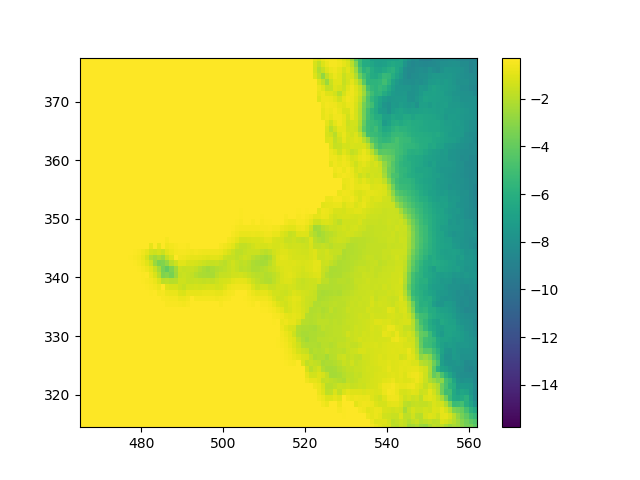

array([[ -9.10959884,  -9.31747142,  -7.22872719, ...,  -9.82995496,
        -10.06069515,  -9.56154148],
       [ -9.21956143,  -8.74146727,  -6.76837993, ...,  -9.74226319,
         -9.56015242,  -9.80656751],
       [ -9.0259521 ,  -8.06852927,  -7.78809313, ..., -10.40301483,
         -9.92042118, -10.02666983],
       ..., 
       [-11.05064856, -10.68654918, -10.31412947, ..., -11.21578577,
        -11.6162329 , -11.53427942],
       [-10.93870256, -10.62707237, -10.46589527, ..., -11.65739656,
        -11.70485804, -11.86279949],
       [-11.40471907, -10.69330391, -10.75760273, ..., -11.88448206,
        -11.97868911, -12.69782536]])

TypeError: 'z_r' object is not callable

<IPython.core.display.Javascript object>


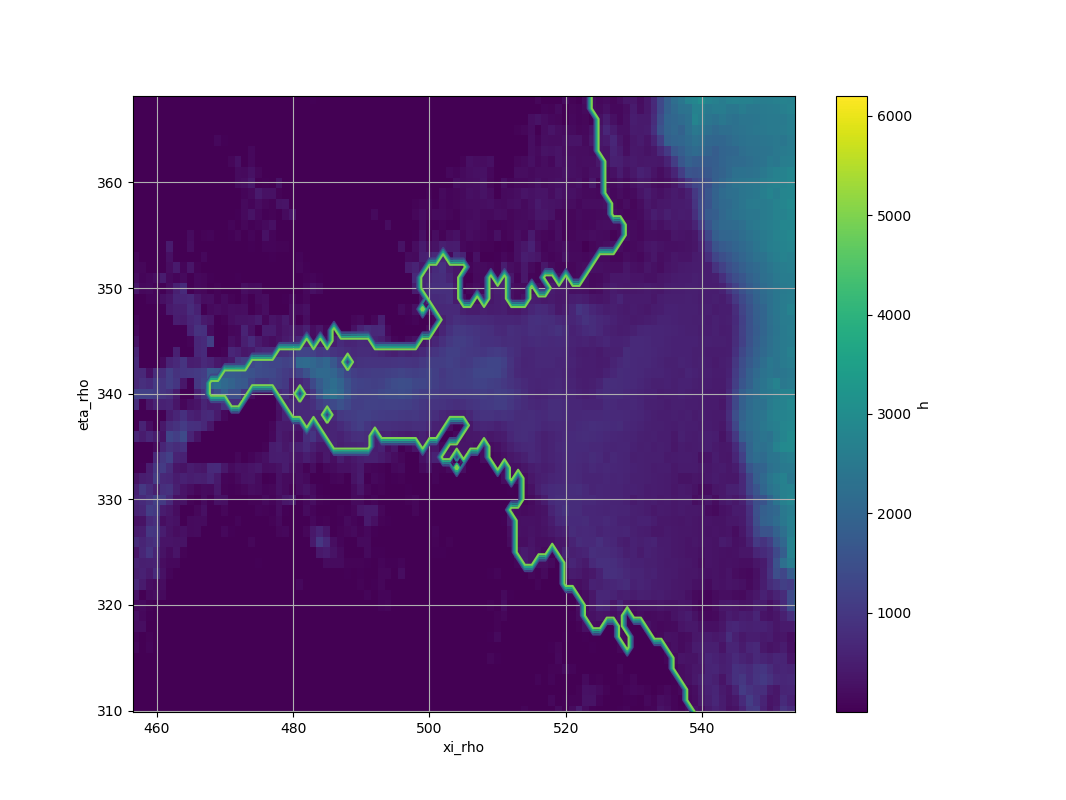

In [34]:
%matplotlib notebook
plt.close()
grd.h.plot(size=8)
grd.mask_rho.plot.contour()
plt.grid()
plt.show()

In [13]:
#amery
%matplotlib inline
plt.close()
for theta_b in [4,6,8,10,12,14]:
    h = grd.h.values
    zice = grd.zice.values
    theta_s = 7
    #theta_b = 10
    hc = 250
    N = grd.s_rho.size
    zeta = np.zeros_like(h)

    depths,s,C = calc_z(h,zice,theta_s,theta_b,hc,N)

    grd = grd.assign_coords(depth = xr.DataArray(depths,dims=['s_rho','eta_rho','xi_rho']))

    layer = np.zeros_like(depths)
    for k in range(N):
        layer[k,:] = k+1
    layer = np.ma.masked_where(grd.mask_3d==0,layer)

    lev = range(1,N)

    eta=range(300,302)
    xi=range(155,158)
    plt.figure(figsize=(12,6))
    plt.contour(xi_3d[:,eta,xi],depths[:,eta,xi],layer[:,eta,xi],lev,colors='k')
    plt.title('Vlayer distribution at Amery ice front for Vtrans=2,Vstre=4,Tcline=250,theta_s=7\n theta_b='+str(theta_b))
    plt.show()

IndexError: shape mismatch: indexing arrays could not be broadcast together with shapes (2,) (3,) 

In [113]:
z_r[:].shape

(31, 530, 630)

<IPython.core.display.Javascript object>


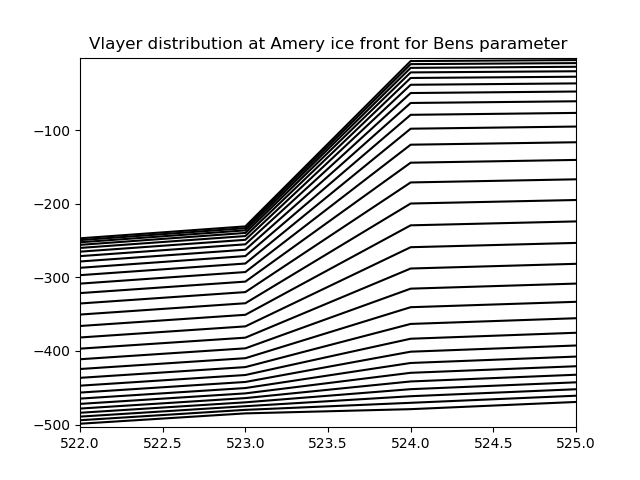

Text(0.5,1,'Vlayer distribution at Amery ice front for Bens parameter')

In [124]:
z_old = z_r[:]+grd.zice.values
plt.close()
plt.contour(xi_3d[:,eta,xi],z_old[:,eta,xi],layer[:,eta,xi],lev,colors='k')
plt.title('Vlayer distribution at Amery ice front for Bens parameter')